# Setup

In [1]:
from transformers import BertTokenizer, BertForSequenceClassification
import os
from modules.utils import SentimentDataset
from datasets import load_dataset
import torch
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from itertools import chain
import numpy as np
from tabulate import tabulate 
import random

2023-05-27 12:45:01.481162: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Defining relevant paths

CURDIR = os.getcwd()
MODELS = os.path.join(CURDIR, 'models')
BERT_PATH = os.path.join(MODELS, 'BERT')


In [3]:
# Loading model from pretrained
tokenizer = BertTokenizer.from_pretrained(BERT_PATH)
model = BertForSequenceClassification.from_pretrained(BERT_PATH)

# Evaluate

In [5]:
# Loading new raw dataset
df = load_dataset('sentiment140')

# Create subset based on new data
test_set = df['train'].to_pandas().groupby('sentiment').apply(lambda x: x[-1000:]).reset_index(drop=True).replace(4, 1).sample(frac=1)

sentences = SentimentDataset(test_set.text.to_list(), subset='test').process_data()
labels = test_set.sentiment.to_list()

Found cached dataset sentiment140 (/Users/krebs/.cache/huggingface/datasets/sentiment140/sentiment140/1.0.0/f81c014152931b776735658d8ae493b181927de002e706c4d5244ecb26376997)


  0%|          | 0/2 [00:00<?, ?it/s]

Processing
Processing test input


In [6]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# Same processes as for training
for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      
                        add_special_tokens = True, 
                        max_length = 70,           
                        pad_to_max_length = True,
                        return_attention_mask = True, 
                        return_tensors = 'pt')     

    # Add the encoded sentence to the list
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding)
    attention_masks.append(encoded_dict['attention_mask'])

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])


# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  home school let early
Token IDs: tensor([[ 101, 2188, 2082, 2292, 2220,  102,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])


In [7]:
# Set the batch size - same as training
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [8]:
# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = tuple(t for t in batch)
  
  # Similarly to validation during training, computing gradient is not necessary
  with torch.no_grad():
      
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().numpy()
  label_ids = b_labels.numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [9]:
test_pred_labels = list(chain.from_iterable(predictions))
test_true_labels = list(chain.from_iterable(true_labels))

In [10]:
test_pred_labels = [np.argmax(pred) for pred in test_pred_labels]

## Accuracy

In [11]:
accuracy_score(test_true_labels, test_pred_labels)

0.799

In [12]:
print(classification_report(test_true_labels, test_pred_labels))


              precision    recall  f1-score   support

           0       0.78      0.82      0.80      1000
           1       0.82      0.77      0.79      1000

    accuracy                           0.80      2000
   macro avg       0.80      0.80      0.80      2000
weighted avg       0.80      0.80      0.80      2000



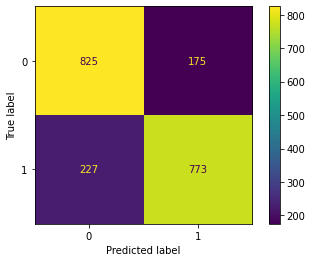

In [13]:
ConfusionMatrixDisplay(confusion_matrix(test_true_labels, test_pred_labels)).plot()


## Error

In [15]:

# Indices of wrong predictions
wrong_predictions = [i for i, (a,b) in enumerate(zip(test_pred_labels, test_true_labels)) if a != b]

# Random list of 5 index positions
indexes = [wrong_predictions[random.randint(0, len(wrong_predictions)-1)] for _ in range(5)]

# Original tweet
original = test_set.text.to_list()

# Processed tweet 
processed = sentences

In [18]:
table = [[original[i], processed[i], test_true_labels[i], test_pred_labels[i]]
         for i in indexes]
print(tabulate(table, headers=["Original Tweet", "Processed Tweet", "True Label", "Predicted Label"]))

Original Tweet                                                                                                             Processed Tweet                                                          True Label    Predicted Label
-------------------------------------------------------------------------------------------------------------------------  ---------------------------------------------------------------------  ------------  -----------------
@gagova75 @QueenM81  after this break, it's time for me to go back to work. BBS &lt;3 Have fun                             break time go back work bb lt fun                                                 1                  0
@Ms_Hip_Hop there will be no sleepin on twitter young lady. LOL im at work these NJ cops are gansta they stoppin everybdy  sleepin twitter young lady lol im work nj cop gansta stoppin everybdy             0                  1
@ISmackYourAss I know now I can't read ur storys                                                